In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D


from sklearn.metrics import roc_curve, confusion_matrix, auc
from imblearn.over_sampling import SMOTE

Import scikit libraries

In [21]:
# --- Model selection utilities ---
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# --- Preprocessing tools ---
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# --- Classification models ---
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
# --- Evaluation metrics ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    auc,
)

from sklearn.inspection import permutation_importance

# 1. Data Loading



In [22]:
df = pd.read_csv('../../data/diabetes.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# 2. Train-Test Split (80/20)

In [23]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Class Balancing (on Training Set Only)
Use SMOTE or ADASYN to upsample minority class (Outcome = 1):

In [24]:
#smote = SMOTE(random_state=42)
#X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# 4. Nested Cross validation for model selection and hyperparameter tuning -> Unbalanced data


--- Working on fold 1 ---
Fold 1 — F1 score: 0.6154
  Best n_neighbors: 9
  Best weights: uniform
  Best metric: manhattan

--- Working on fold 2 ---
Fold 2 — F1 score: 0.5895
  Best n_neighbors: 7
  Best weights: uniform
  Best metric: manhattan

--- Working on fold 3 ---
Fold 3 — F1 score: 0.5806
  Best n_neighbors: 9
  Best weights: uniform
  Best metric: manhattan

--- Working on fold 4 ---
Fold 4 — F1 score: 0.5895
  Best n_neighbors: 9
  Best weights: distance
  Best metric: manhattan

--- Working on fold 5 ---
Fold 5 — F1 score: 0.5607
  Best n_neighbors: 11
  Best weights: distance
  Best metric: manhattan


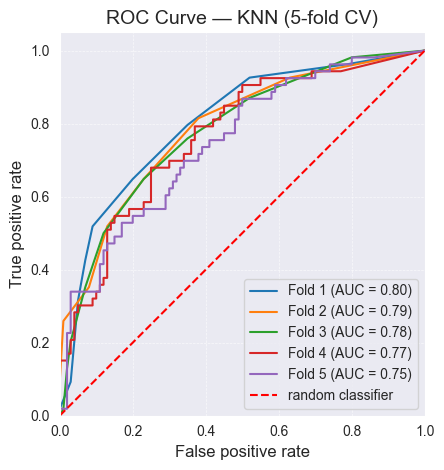

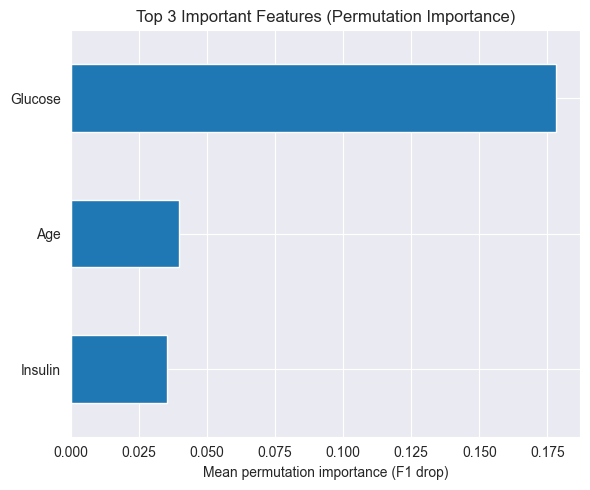

In [51]:
# Parameter grid
parameters = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}


# Initialize permutation importance matrix
perm_importance_matrix = pd.DataFrame(index=X.columns)

# Reset previous storage
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
models = []
f1_scores = []
roc_curves = []
perm_importance_matrix = pd.DataFrame(index=X.columns)
fold = 1

# Re-run the loop with permutation importance added
for train_index, test_index in cv.split(X, y):
    print(f'\n--- Working on fold {fold} ---')

    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Grid search
    knn = KNeighborsClassifier()
    clf_GS = GridSearchCV(knn, parameters, cv=5, scoring='f1')
    clf_GS.fit(X_train, y_train)

    # Best model from grid search
    best_model = clf_GS.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc, fold))
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Fold {fold} — F1 score: {f1:.4f}")
    print('  Best n_neighbors:', best_model.get_params()['n_neighbors'])
    print('  Best weights:', best_model.get_params()['weights'])
    print('  Best metric:', best_model.get_params()['metric'])

    # Store metrics and model
    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    models.append(best_model)
    f1_scores.append(f1)

    # Permutation importance on validation set
    result = permutation_importance(
        best_model, X_test, y_test, scoring='f1', n_repeats=10, random_state=fold
    )
    perm_importance_matrix[f'fold_{fold}'] = result.importances_mean

    fold += 1

# Identify best model
best_index = f1_scores.index(max(f1_scores))
best_model_overall = models[best_index]

bnn = best_model_overall.get_params()["n_neighbors"]
bw = best_model_overall.get_params()["weights"]
bm = best_model_overall.get_params()["metric"]
b_model = KNeighborsClassifier(n_neighbors=bnn, weights=bw, metric=bm)

# Final ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='random classifier')
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.title('ROC Curve — KNN (5-fold CV)', fontsize=14)
plt.legend(loc='lower right', fontsize=10, frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Compute average feature importance across folds
mean_perm_importance = perm_importance_matrix.mean(axis=1)
top_features = mean_perm_importance.sort_values(ascending=False).head(3)

top_features.plot(kind='barh', figsize=(6, 5))
plt.xlabel("Mean permutation importance (F1 drop)")
plt.title("Top 3 Important Features (Permutation Importance)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 5. Evaluation Metrics and Visualization

In [50]:
# ROC Curve per outer fold
# Final ROC for best model
# F1-score and confusion matrix on test set
# Save best model for interpretation

# Calculate mean and std of the metrics
mean_metrics = {key: np.mean(values) for key, values in metrics.items()}
std_metrics = {key: np.std(values) for key, values in metrics.items()}

# Print mean and std
for key, value in mean_metrics.items():
    print('{}: {:.3f} ± {:.3f}'.format(key.capitalize(), value, std_metrics[key]))

print(mean_perm_importance)

Accuracy: 0.741 ± 0.026
Precision: 0.671 ± 0.065
Recall: 0.526 ± 0.022
F1: 0.587 ± 0.018
Pregnancies                -0.000457
Glucose                     0.178034
BloodPressure               0.010108
SkinThickness              -0.018431
Insulin                     0.035226
BMI                         0.005745
DiabetesPedigreeFunction    0.001095
Age                         0.039655
dtype: float64


# 6. Permuation feature importance

In [47]:
#perm_result = permutation_importance(best_model, X_test, y_test, scoring='f1', n_repeats=30, random_state=42)

print(b_model)

KNeighborsClassifier(metric='manhattan', n_neighbors=9)


# 7. Decision Threshold & Interpretation

In [ ]:
prob = best_model.predict_proba(X_test)[:, 1]
plt.scatter(X_test["Glucose"], prob, c=y_test, cmap="bwr")
plt.axhline(0.5, linestyle="--", color="gray")


Top 2 features for Voronoi visualization: ['Glucose', 'Age']


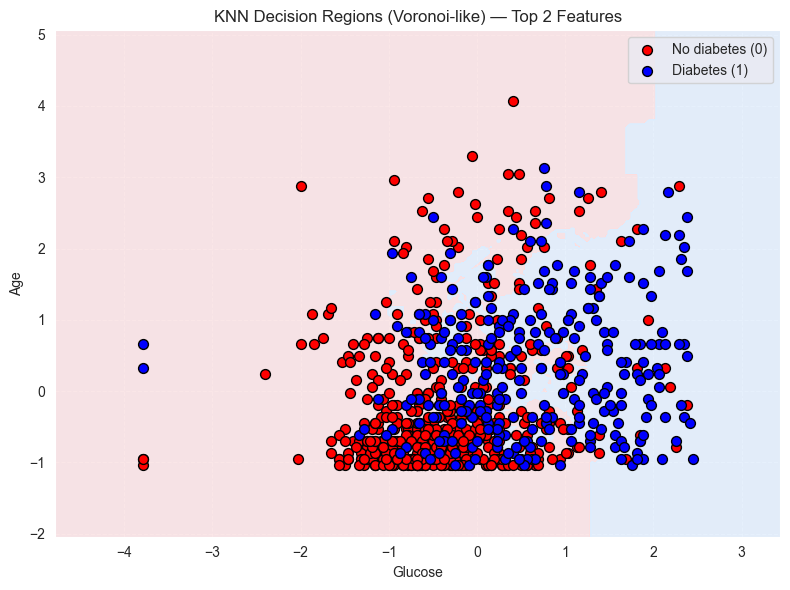

In [56]:
from matplotlib.colors import ListedColormap

# Get top 2 features
top_2 = top_features.index[:2]
print(f"Top 2 features for Voronoi visualization: {top_2.tolist()}")

# Extract feature matrix and labels
X_2d = X[top_2].values
y_2d = y.values

# Standardize features
scaler_2d = StandardScaler()
X_2d_std = scaler_2d.fit_transform(X_2d)

# Retrain KNN on 2D standardized features
knn_2d = KNeighborsClassifier(n_neighbors=bnn, weights=bw, metric=bm)
knn_2d.fit(X_2d_std, y_2d)

# Meshgrid for decision region
h = 0.02
x_min, x_max = X_2d_std[:, 0].min() - 1, X_2d_std[:, 0].max() + 1
y_min, y_max = X_2d_std[:, 1].min() - 1, X_2d_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define color maps
cmap_light = ListedColormap(['#FFDDDD', '#DDEEFF'])  # decision regions
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # actual points

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

# Plot training points with legend labels
for cls, color, label in zip([0, 1], ['#FF0000', '#0000FF'], ['No diabetes (0)', 'Diabetes (1)']):
    plt.scatter(X_2d_std[y_2d == cls, 0], X_2d_std[y_2d == cls, 1],
                c=color, edgecolor='k', label=label, s=50)

plt.xlabel(top_2[0])
plt.ylabel(top_2[1])
plt.title("KNN Decision Regions (Voronoi-like) — Top 2 Features")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Top 3 features: ['Glucose', 'Age', 'Insulin']


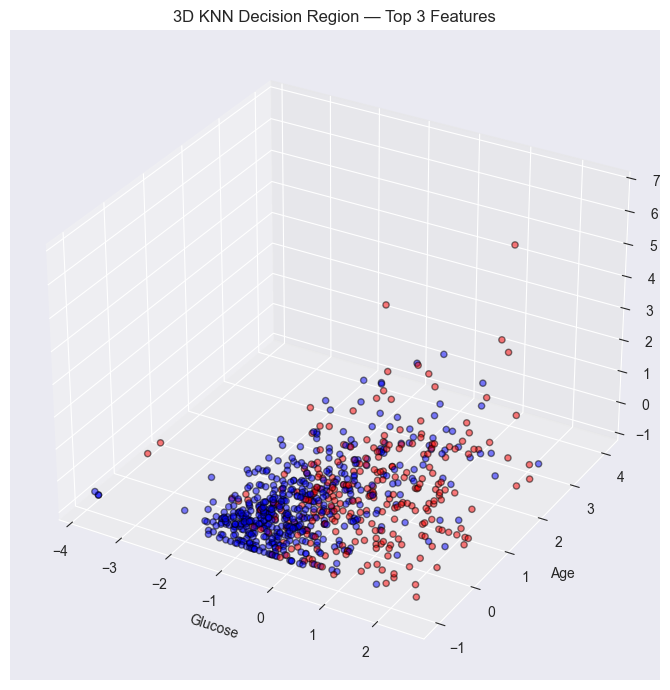

In [57]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Get top 3 features
top_3 = top_features.index[:3]
print(f"Top 3 features: {top_3.tolist()}")

# Prepare data
X_3d = X[top_3].values
y_3d = y.values

# Standardize
scaler_3d = StandardScaler()
X_3d_std = scaler_3d.fit_transform(X_3d)

# Fit KNN model
knn_3d = KNeighborsClassifier(n_neighbors=bnn, weights=bw, metric=bm)
knn_3d.fit(X_3d_std, y_3d)

# Create a 3D grid
grid_size = 30  # reduce if too slow
x_range = np.linspace(X_3d_std[:, 0].min(), X_3d_std[:, 0].max(), grid_size)
y_range = np.linspace(X_3d_std[:, 1].min(), X_3d_std[:, 1].max(), grid_size)
z_range = np.linspace(X_3d_std[:, 2].min(), X_3d_std[:, 2].max(), grid_size)
xx, yy, zz = np.meshgrid(x_range, y_range, z_range)

# Flatten and predict
grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
probs = knn_3d.predict_proba(grid)[:, 1]
probs = probs.reshape(xx.shape)

# Plot decision boundary: P = 0.5
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot iso-surface where P ≈ 0.5 using contouring
ax.scatter(X_3d_std[:, 0], X_3d_std[:, 1], X_3d_std[:, 2], c=y_3d,
           cmap='bwr', alpha=0.5, edgecolor='k', label='Samples')

# Optionally: plot a slice or use colors to represent probabilities
# Full isosurface requires more advanced packages (e.g., plotly, mayavi)

ax.set_xlabel(top_3[0])
ax.set_ylabel(top_3[1])
ax.set_zlabel(top_3[2])
ax.set_title("3D KNN Decision Region — Top 3 Features")
plt.tight_layout()
plt.show()
